In [1]:
# Enable if on M1/2 mac
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [75]:
import src.halfar_ice as hi
import torch
from torch import tensor as t
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import numpy as np

plt.rcParams.update({
    'font.family': 'Courier New',
    'font.size': 10,
    'figure.facecolor': 'lightgray',
    'axes.facecolor': 'lightgray',
})

# Simulation of Ice Dome

Iteration 00299/300; Div 0.004920


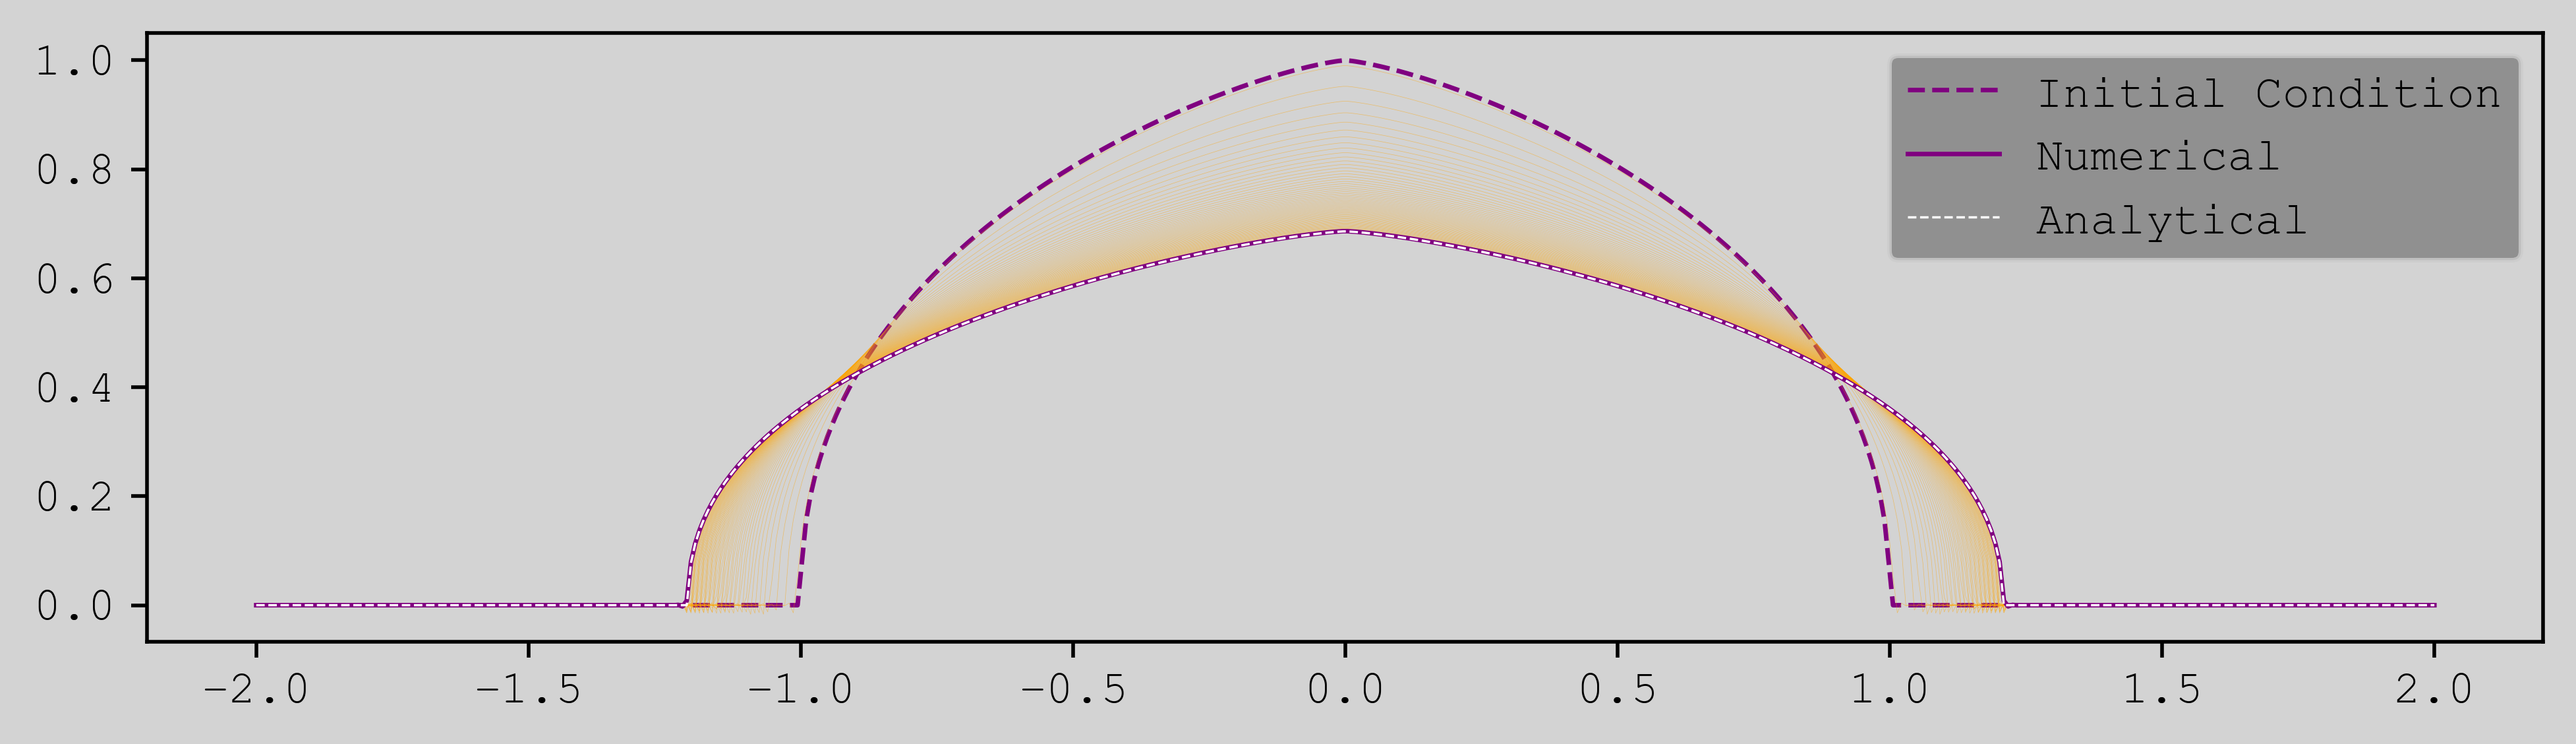

In [3]:
# Instantiate the numeric halfar ice model
num_hi_model = hi.HalfarIceNonLinearPolar(n_elements=511)

# Domain will be from -2. to 2. HalfarIceNonLinearPolar uses a lagrangian FE space of degree 1, meaning
#  our solutions will have n_elements + 1 points. x here is the radius of a radially symmetric dome of ice.
xx = torch.linspace(-2., 2., num_hi_model.n_elements + 1)

# Declare some ground truth parameters affecting flow and deformation rates.
true_ice_density = t(910.).double()
true_log_flow_rate = torch.log(t(1e-16)).double()

# The initial height and radius of the glacier in the standard dome shape.
h0, r0 = 1., 1.

# The gamma term is a constant affecting overall flow rates.
gamma = hi.stable_gamma(rho=true_ice_density, lA=true_log_flow_rate)

# The start time of the analytic solution, somewhat oddly, depends on the above parameters.
t0 = hi.t0f(r0, h0, gamma)

# Generate a halfar dome — with the above parameters — as the initial condition.
u_init = hi.halfar_ice_analytical(r=xx, t=t0, h0=h0, r0=r0, gamma=gamma)
# Massage into a shape expected by torch-fenics, and declare this as a leaf tensor for gradients.
u_init = u_init[None, :].double().clone().detach().requires_grad_(True)

# We'll employ a time stepping solution, so declare the initial condition as the last solution.
u_last_t = u_init

# Prepare a list of solutions vectors (one for each timestep).
sols = [u_last_t[0]]

# Our timestep is 1000...time units (years? days?)
tstep = t(1000).double()[None, None]

# Take 300 steps of 1000...time units.
num_steps = 300
for i in range(num_steps):
    # Track the change in the solution from the previous iteration, simply for logging purposes.
    if len(sols) > 1:
        change = torch.linalg.norm(sols[-1] - sols[-2])
        change = change.item()
    else:
        change = torch.inf
    print(f"\rIteration {i:05d}/{num_steps}; Div {change:6.6f}", end='')

    # Execute the solver and append the solution to the list.
    u_last_t = num_hi_model(tstep, u_last_t, *torch.atleast_2d(true_ice_density, true_log_flow_rate))
    sols.append(u_last_t[0])
print()

fig, ax = plt.subplots(dpi=500, figsize=(8, 4))
hi.plot_sols(xx, sols, ax, skip=5, final_sol_lbl="Numerical")

# Compute the analytical solution at the end (absolute) time.
analytical_end_state = hi.halfar_ice_analytical(xx, t=t0 + num_steps * tstep.item(), h0=h0, r0=r0, gamma=gamma)

plt.plot(xx, analytical_end_state, color='white', linestyle='--',
         linewidth=0.5, label="Analytical")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.legend(facecolor='gray')
plt.show()

In [4]:
# As an aside, both the analytical and numeric solutions function in polar coordinates, and thus their preservation of volume
#  (due to constant density and no flux boundary conditions) can only be seen when scaling by the radius.
print(f"Glacier Mass Before == c*{(xx.abs() * u_init).sum().item()}")
print(f"Glacier Mass After == c*{(xx.abs() * sols[-1]).sum().item()}")

Glacier Mass Before == c*80.31409517847527
Glacier Mass After == c*80.31409470434072


### Gradients Work!

In [8]:
# Now, we check for proper gradients.
# Grab a point just the left of center.
poi_idx = num_hi_model.n_elements // 2 - 10

# Get gradients with respect to the final dome height at that point.
poi = sols[-1][poi_idx]
poi.backward()

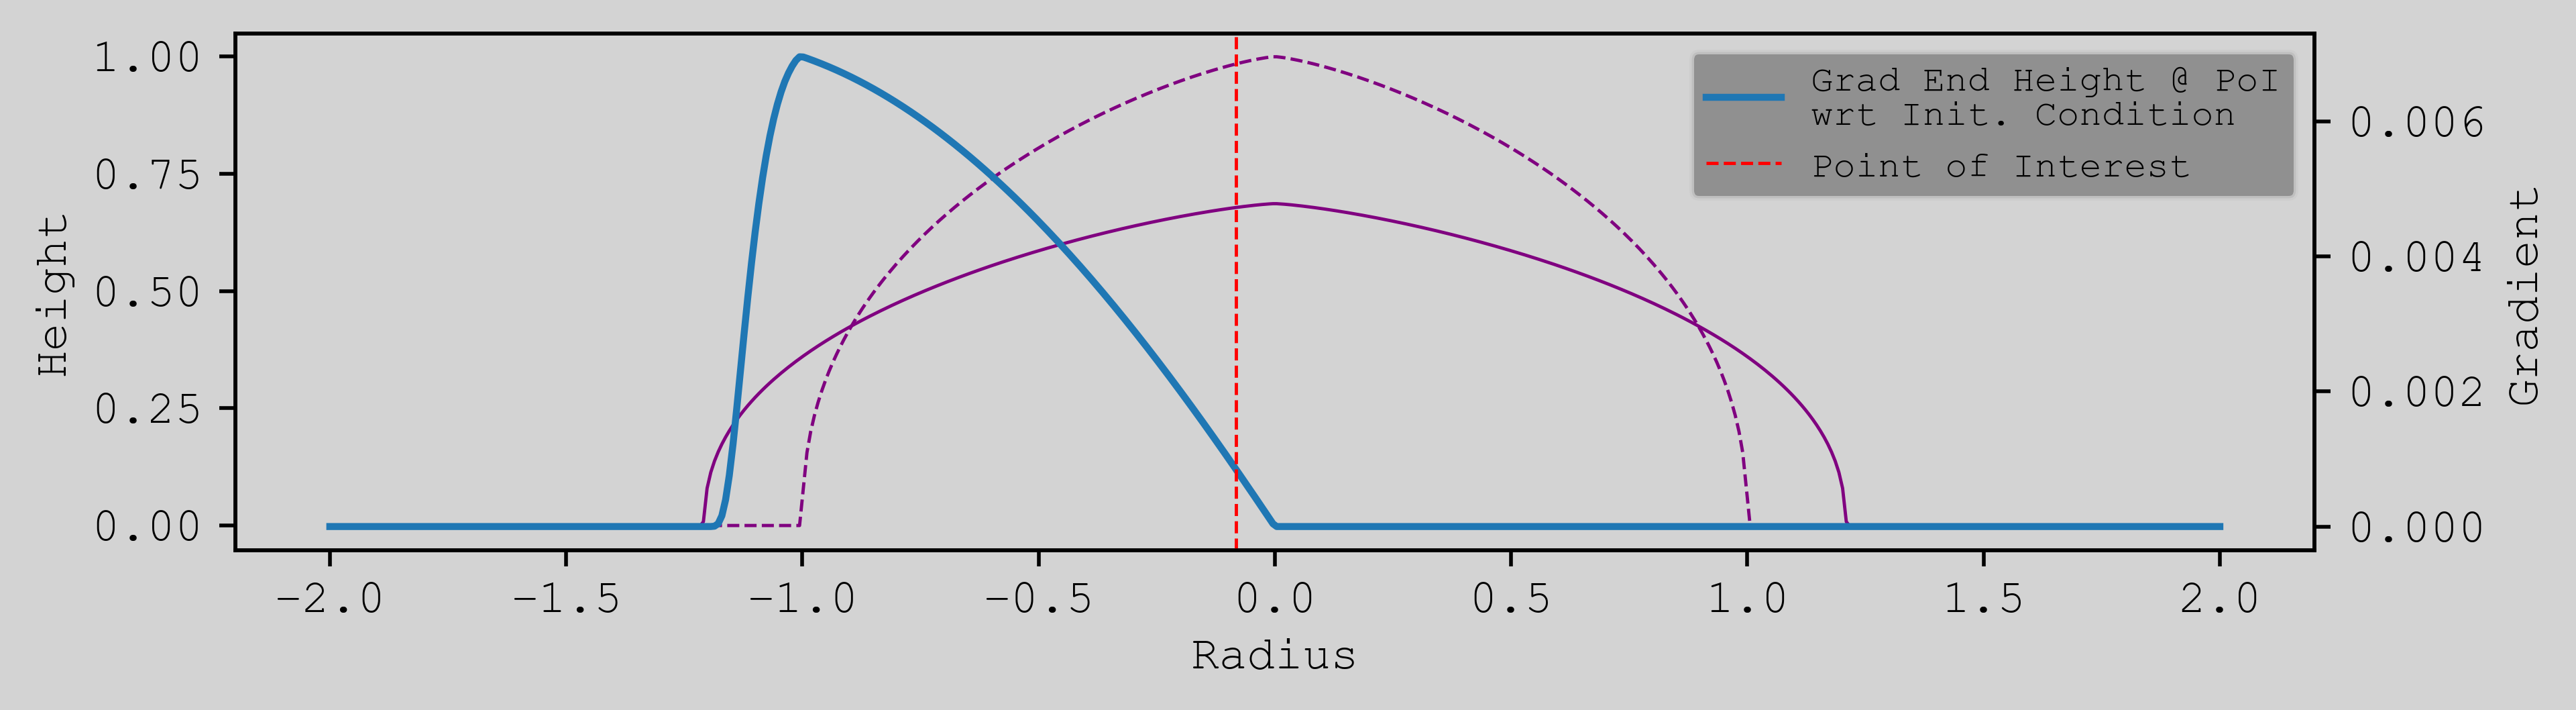

In [9]:
_, ax1 = plt.subplots(figsize=(8, 2), dpi=500)

ax1.plot(xx, u_init[0].detach(), color='purple', linestyle='--', linewidth=0.7)
ax1.plot(xx, sols[-1].detach(), color='purple', linewidth=0.7)
ax1.set_ylabel("Height")
ax1.set_xlabel("Radius")

ax2 = ax1.twinx()
ax2.plot(xx, u_init.grad[0].detach(), label='Grad End Height @ PoI\nwrt Init. Condition')
ax2.axvline(xx[poi_idx], color='red', linestyle='--', label='Point of Interest', linewidth=0.7)
ax2.set_ylabel("Gradient")
ax2.legend(facecolor='gray', fontsize=8)

### Measuring Glacier Depth

In [66]:
# Analytically simulate a glacier and noisily measure its depth at 10 separate times across 5 points on the left slope.
measurement_times = t([t0 + tstep.item() * i for i in range(0,50,5)]).double()
# We'll take measurements on the mesh. TODO figure out measurements that are not on the mesh.
measurement_poi_idx = torch.linspace(130, 256, 5, dtype=torch.int64)
measurement_poi = xx[measurement_poi_idx]

# Generate the true depths.
true_depths = hi.halfar_ice_analytical(r=measurement_poi[None, :], t=measurement_times[:, None], h0=h0, r0=r0, gamma=gamma)

##### Define a Measurement Noise Model in Pyro

In [70]:
def measurement_noise(true_depths_, noise_scale=0.05):
    return pyro.sample("measurements", dist.Normal(true_depths_, noise_scale))
measurements = measurement_noise(true_depths)

In [71]:
measurements

tensor([[0.2400, 0.6087, 0.7954, 0.9638, 0.9917],
        [0.2665, 0.5943, 0.7732, 0.8660, 0.9380],
        [0.3233, 0.6110, 0.7533, 0.8455, 0.9286],
        [0.2977, 0.5870, 0.7588, 0.8998, 0.9009],
        [0.3362, 0.6298, 0.7499, 0.8695, 0.8752],
        [0.3444, 0.5926, 0.7399, 0.8160, 0.8887],
        [0.3636, 0.5771, 0.6979, 0.7843, 0.8488],
        [0.3476, 0.5560, 0.7375, 0.8052, 0.8634],
        [0.3690, 0.5587, 0.6899, 0.8073, 0.8489],
        [0.3624, 0.5663, 0.6938, 0.7762, 0.8496]], dtype=torch.float64)

NameError: name 'np' is not defined

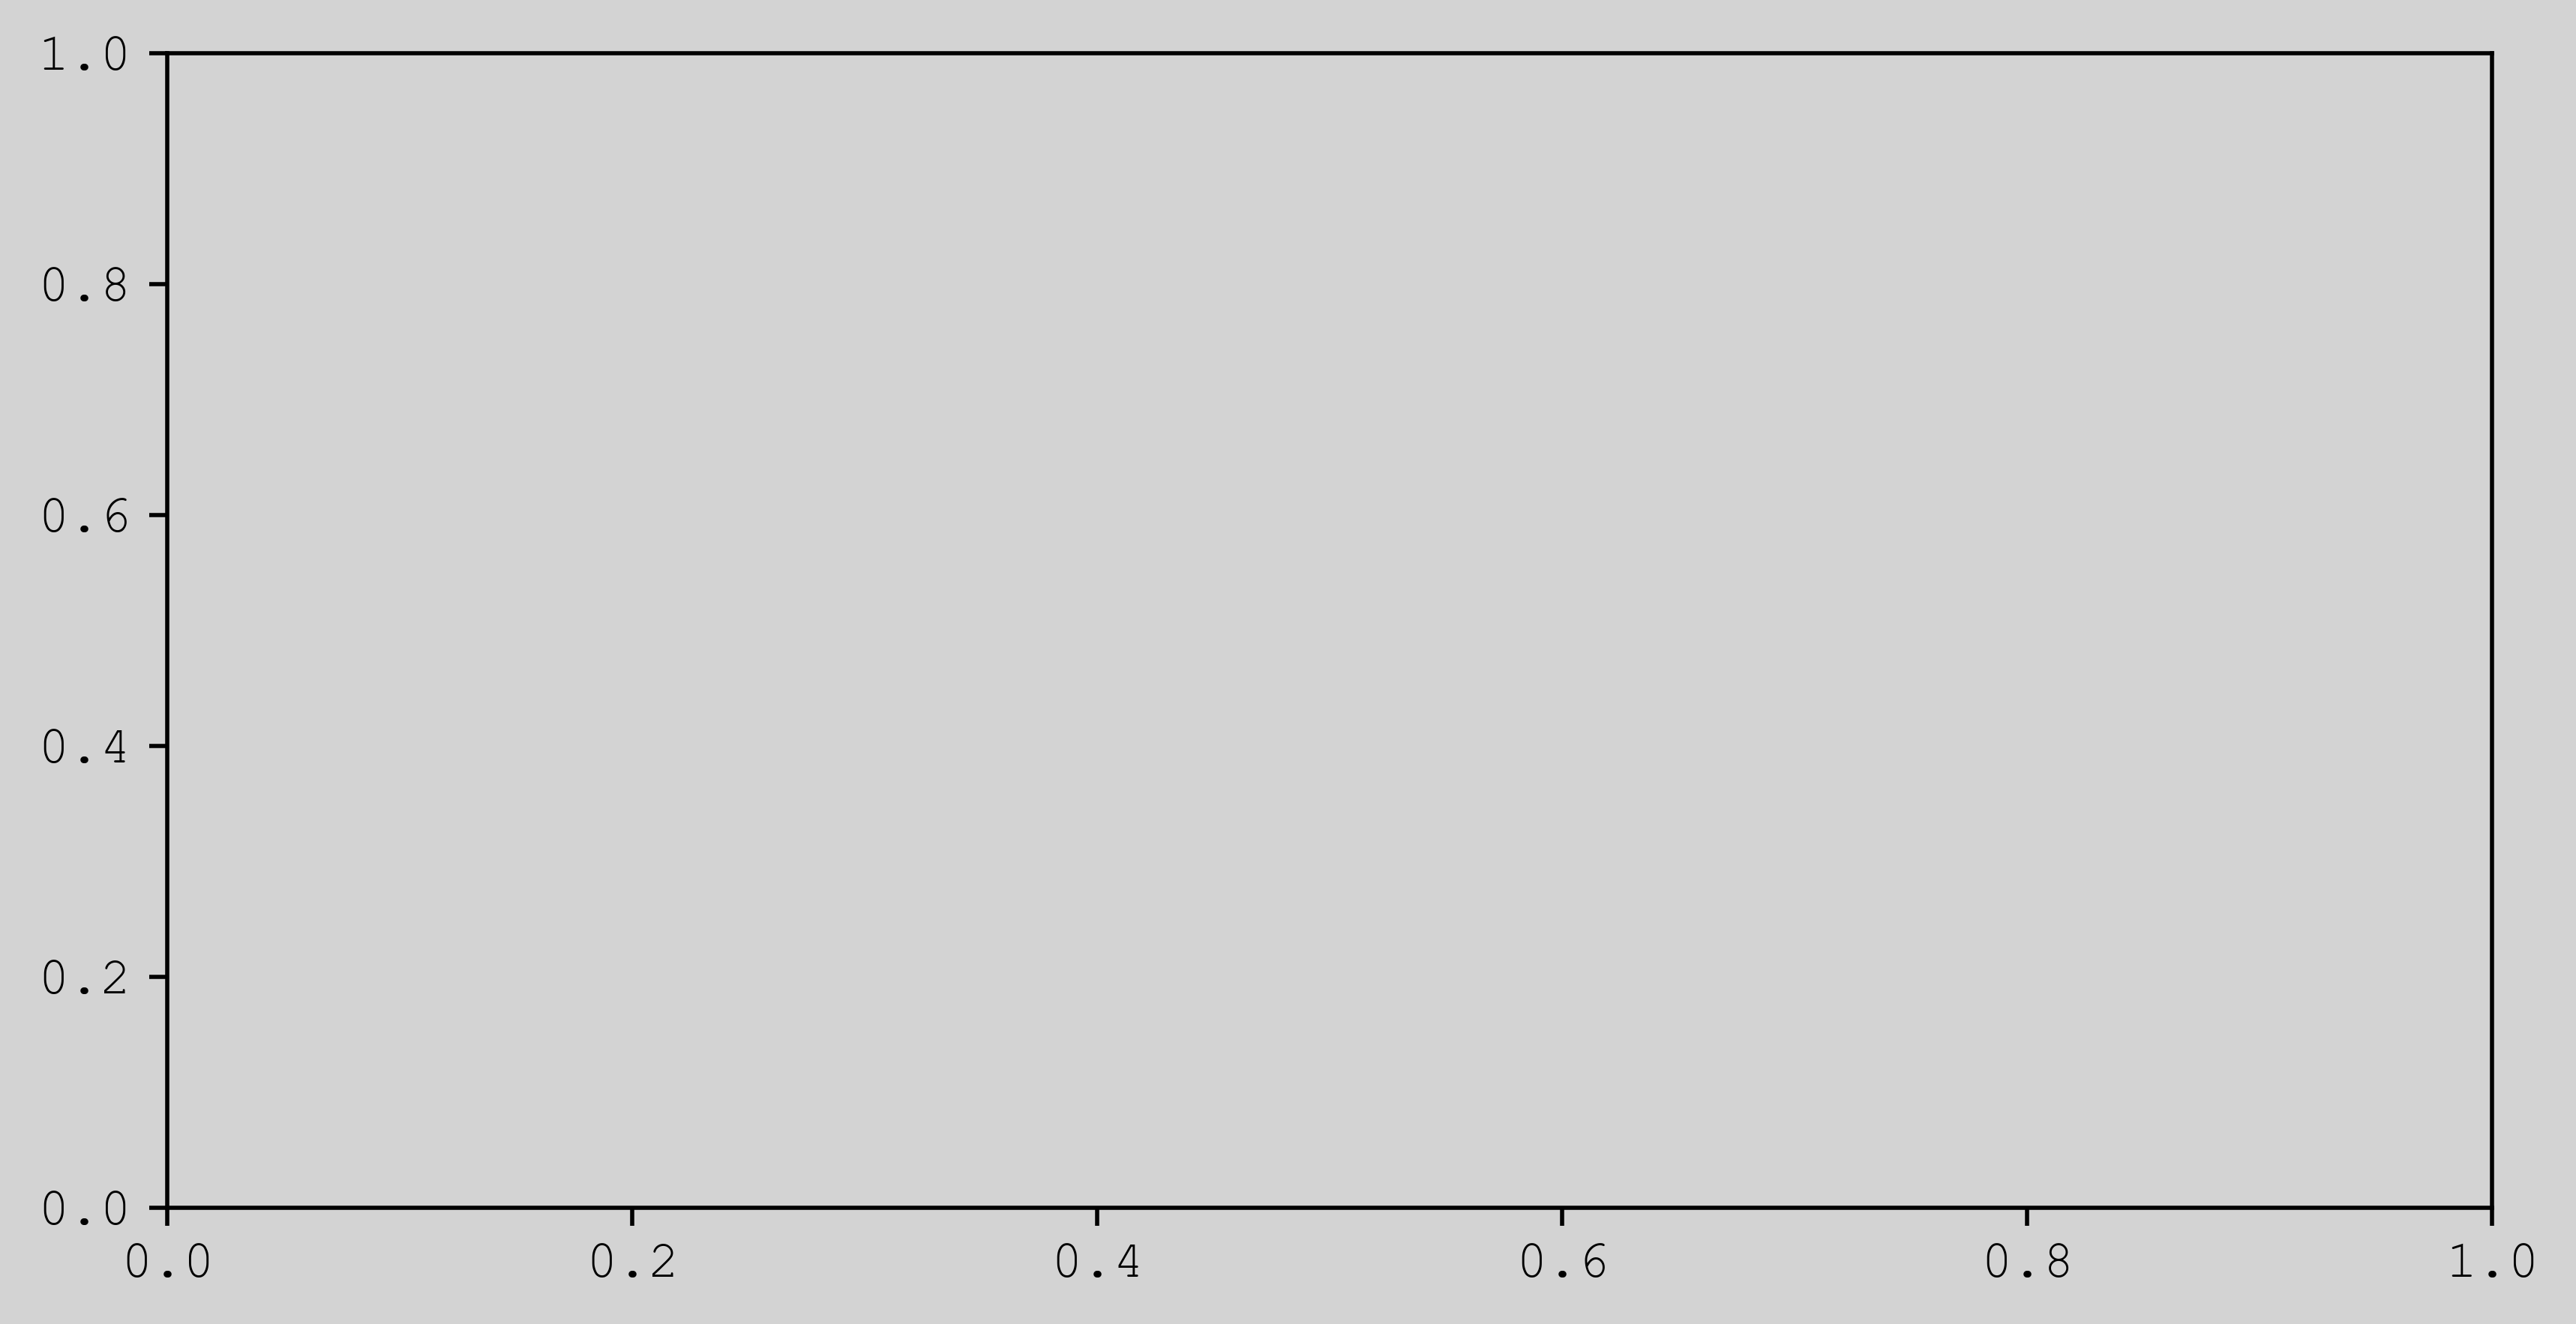

In [74]:
# Plot just a line connecting the measurements in a thin orange line. Increase opacity as more measurements are taken.
fig, ax = plt.subplots(dpi=500, figsize=(8, 4))
ax.plot(measurement_poi, measurements.T, color='orange', linewidth=0.5, alpha=0.1 * np.arange(measurements.shape[0]))
ax.set_ylabel("Height")
ax.set_xlabel("Radius")
ax.set_title("Measurements")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()
